## Архитектуры нейронок для рахных задач

In [ ]:
# 1. Координаты X, Y, TVD1 и TVD2 лежат отдельными листами в .xlsx файле
# 2. Файлов .tfrecord не пугаться, в деталях коммита на всякий указал как открывать такие. 
# Там 4 таких файла уже в порядке следования дат, для нефти, воды, пластового и забойного.
# Каждый тензор размерности [121,6,6]. 
# 3. Чтобы узнать какой дате соответствует индекс в тензоре, можно заюзать файл Dates_processed.csv.
# Загружаете как датафрейм и запрашиваете по индексу строки, получаете дату.

In [140]:
# imports 

import tensorflow as tf
import os 
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, TimeDistributed, Input, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [200]:
# specify your directory where files are located 
# tensors loading

files_dir = '../data/processed/'
loaded_tensors = dict()
for file in [x for x in os.listdir(files_dir) if x.endswith("tfrecord")]:
    serialized_tensor = tf.io.read_file(os.path.join(files_dir,file))
    loaded_tensors[file] = tf.io.parse_tensor(serialized_tensor, out_type=tf.float32)

# coordinates loading 
df_coords = pd.read_excel(os.path.join(files_dir,"Coordinates_processed.xlsx"),sheet_name=['X','Y','TVD1','TVD2'],header=None)
df_X_Y = pd.DataFrame({col: list(zip(df_coords["X"][col], df_coords["Y"][col])) for col in  df_coords["X"].columns})
df_TVD = pd.DataFrame({col: list(zip(df_coords["TVD1"][col], df_coords["TVD2"][col])) for col in  df_coords["TVD1"].columns})

# time loading 
time_sequence = pd.read_csv(os.path.join(files_dir,"Dates_processed.csv"))

In [ ]:
# Параметры
total_time_steps = 121  # Общее количество временных точек
train_time_steps = 84   # Количество временных точек для обучения (до 2027 года)
test_time_steps = total_time_steps - train_time_steps  # Количество временных точек для тестирования

map_height = 6    # Высота карты (матрицы)
map_width = 6     # Ширина карты (матрицы)
batch_size = 1    # Размер пакета

# Входы для обучающей модели
input_oil_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_oil')
input_water_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_water')
input_reservoir_pressure_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_reservoir_pressure')
input_bottomhole_pressure_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_bottomhole_pressure')

# Входы для тестовой модели
input_oil_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_oil')
input_water_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_water')
input_reservoir_pressure_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_reservoir_pressure')
input_bottomhole_pressure_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_bottomhole_pressure')

# CNN для каждого вида данных
def create_cnn(input_tensor):
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(input_tensor)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(x)
    x = TimeDistributed(Flatten())(x)
    return x

# Модель для обучения
cnn_oil_train = create_cnn(input_oil_train)
cnn_water_train = create_cnn(input_water_train)
cnn_reservoir_pressure_train = create_cnn(input_reservoir_pressure_train)
cnn_bottomhole_pressure_train = create_cnn(input_bottomhole_pressure_train)

merged_cnn_train = Concatenate(axis=-1)([cnn_oil_train, cnn_water_train, cnn_reservoir_pressure_train, cnn_bottomhole_pressure_train])
lstm_out_train = LSTM(128, return_sequences=False)(merged_cnn_train)
output_train = Dense(1, activation='linear', name='output')(lstm_out_train)

model_train = Model(inputs=[input_oil_train, input_water_train, input_reservoir_pressure_train, input_bottomhole_pressure_train], outputs=output_train)
model_train.compile(optimizer='adam', loss='mse')

# Модель для тестирования
cnn_oil_test = create_cnn(input_oil_test)
cnn_water_test = create_cnn(input_water_test)
cnn_reservoir_pressure_test = create_cnn(input_reservoir_pressure_test)
cnn_bottomhole_pressure_test = create_cnn(input_bottomhole_pressure_test)

merged_cnn_test = Concatenate(axis=-1)([cnn_oil_test, cnn_water_test, cnn_reservoir_pressure_test, cnn_bottomhole_pressure_test])
lstm_out_test = LSTM(128, return_sequences=False)(merged_cnn_test)
output_test = Dense(1, activation='linear', name='output')(lstm_out_test)

model_test = Model(inputs=[input_oil_test, input_water_test, input_reservoir_pressure_test, input_bottomhole_pressure_test], outputs=output_test)
model_test.compile(optimizer='adam', loss='mse')

# Загрузка данных из тензоров
oil_data = np.expand_dims(loaded_tensors['debit_neft_series.tfrecord'].numpy(), axis=-1)
water_data = np.expand_dims(loaded_tensors['debit_water_series.tfrecord'].numpy(), axis=-1)
reservoir_pressure_data = np.expand_dims(loaded_tensors['debit_plast_pressure_series.tfrecord'].numpy(), axis=-1)
bottomhole_pressure_data = np.expand_dims(loaded_tensors['debit_zaboy_pressure_series.tfrecord'].numpy(), axis=-1)

# Проверка форм данных
print("Oil data shape:", oil_data.shape)
print("Water data shape:", water_data.shape)
print("Reservoir pressure data shape:", reservoir_pressure_data.shape)
print("Bottomhole pressure data shape:", bottomhole_pressure_data.shape)

# Убедимся, что формы данных совпадают с ожидаемой формой
oil_data = oil_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
water_data = water_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
reservoir_pressure_data = reservoir_pressure_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
bottomhole_pressure_data = bottomhole_pressure_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))

# Разделим данные на обучающую и тестовую выборки
oil_train = oil_data[:, :train_time_steps, :, :, :]
water_train = water_data[:, :train_time_steps, :, :, :]
reservoir_pressure_train = reservoir_pressure_data[:, :train_time_steps, :, :, :]
bottomhole_pressure_train = bottomhole_pressure_data[:, :train_time_steps, :, :, :]

oil_test = oil_data[:, train_time_steps:, :, :, :]
water_test = water_data[:, train_time_steps:, :, :, :]
reservoir_pressure_test = reservoir_pressure_data[:, train_time_steps:, :, :, :]
bottomhole_pressure_test = bottomhole_pressure_data[:, train_time_steps:, :, :, :]

# Дебит нефти для обучения и тестирования
output_train = oil_data[:, :train_time_steps, map_height//2, map_width//2, 0].reshape((batch_size, train_time_steps, 1))
output_test = oil_data[:, train_time_steps:, map_height//2, map_width//2, 0].reshape((batch_size, test_time_steps, 1))

# Обучение модели
history = model_train.fit([oil_train, water_train, reservoir_pressure_train, bottomhole_pressure_train], output_train, epochs=1000)

# Построение кривых обучения
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Оценка модели на тестовых данных
test_loss = model_test.evaluate([oil_test, water_test, reservoir_pressure_test, bottomhole_pressure_test], output_test)
print(f'Test Loss: {test_loss}')

### Добавление координат X и Y

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, TimeDistributed, LSTM, Dense, Concatenate, RepeatVector, Reshape
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Parameters
total_time_steps = 121  # Total time steps
train_time_steps = 84   # Time steps for training (up to 2027)
test_time_steps = total_time_steps - train_time_steps  # Time steps for testing

map_height = 6    # Map height (matrix)
map_width = 6     # Map width (matrix)
batch_size = 1    # Batch size

# Input tensors for training model
input_oil_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_oil')
input_water_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_water')
input_reservoir_pressure_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_reservoir_pressure')
input_bottomhole_pressure_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_bottomhole_pressure')
input_coordinates_train = Input(shape=(map_height, map_width, 2), name='input_coordinates')  # New input

# Input tensors for testing model
input_oil_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_oil')
input_water_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_water')
input_reservoir_pressure_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_reservoir_pressure')
input_bottomhole_pressure_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_bottomhole_pressure')
input_coordinates_test = Input(shape=(map_height, map_width, 2), name='input_coordinates')  # New input

# CNN for each type of data
def create_cnn(input_tensor):
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(input_tensor)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(x)
    x = TimeDistributed(Flatten())(x)
    return x

# Training model
cnn_oil_train = create_cnn(input_oil_train)
cnn_water_train = create_cnn(input_water_train)
cnn_reservoir_pressure_train = create_cnn(input_reservoir_pressure_train)
cnn_bottomhole_pressure_train = create_cnn(input_bottomhole_pressure_train)

# Processing coordinates and reshaping
flattened_coordinates_train = Flatten()(input_coordinates_train)
repeated_coordinates_train = RepeatVector(train_time_steps)(flattened_coordinates_train)

# Concatenating all inputs
merged_cnn_train = Concatenate(axis=-1)([cnn_oil_train, cnn_water_train, cnn_reservoir_pressure_train, cnn_bottomhole_pressure_train, repeated_coordinates_train])
lstm_out_train = LSTM(128, return_sequences=False)(merged_cnn_train)
output_train = Dense(map_height * map_width, activation='linear', name='output')(lstm_out_train)
output_train = Reshape((map_height, map_width))(output_train)

model_train = Model(inputs=[input_oil_train, input_water_train, input_reservoir_pressure_train, input_bottomhole_pressure_train, input_coordinates_train], outputs=output_train)
model_train.compile(optimizer='adam', loss='mse')

# Testing model
cnn_oil_test = create_cnn(input_oil_test)
cnn_water_test = create_cnn(input_water_test)
cnn_reservoir_pressure_test = create_cnn(input_reservoir_pressure_test)
cnn_bottomhole_pressure_test = create_cnn(input_bottomhole_pressure_test)

# Processing coordinates and reshaping
flattened_coordinates_test = Flatten()(input_coordinates_test)
repeated_coordinates_test = RepeatVector(test_time_steps)(flattened_coordinates_test)

# Concatenating all inputs
merged_cnn_test = Concatenate(axis=-1)([cnn_oil_test, cnn_water_test, cnn_reservoir_pressure_test, cnn_bottomhole_pressure_test, repeated_coordinates_test])
lstm_out_test = LSTM(128, return_sequences=False)(merged_cnn_test)
output_test = Dense(map_height * map_width, activation='linear', name='output')(lstm_out_test)
output_test = Reshape((map_height, map_width))(output_test)

model_test = Model(inputs=[input_oil_test, input_water_test, input_reservoir_pressure_test, input_bottomhole_pressure_test, input_coordinates_test], outputs=output_test)
model_test.compile(optimizer='adam', loss='mse')

# Loading data from tensors
oil_data = np.expand_dims(loaded_tensors['debit_neft_series.tfrecord'].numpy(), axis=-1)
water_data = np.expand_dims(loaded_tensors['debit_water_series.tfrecord'].numpy(), axis=-1)
reservoir_pressure_data = np.expand_dims(loaded_tensors['debit_plast_pressure_series.tfrecord'].numpy(), axis=-1)
bottomhole_pressure_data = np.expand_dims(loaded_tensors['debit_zaboy_pressure_series.tfrecord'].numpy(), axis=-1)

# Transforming df_X_Y to numpy array of required shape
coordinates_data = np.array(df_X_Y.applymap(lambda x: list(x)).values.tolist())
coordinates_data = coordinates_data.reshape((batch_size, map_height, map_width, 2))

# Checking data shapes
print("Oil data shape:", oil_data.shape)
print("Water data shape:", water_data.shape)
print("Reservoir pressure data shape:", reservoir_pressure_data.shape)
print("Bottomhole pressure data shape:", bottomhole_pressure_data.shape)
print("Coordinates data shape:", coordinates_data.shape)

# Ensure data shapes match expected shape
oil_data = oil_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
water_data = water_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
reservoir_pressure_data = reservoir_pressure_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
bottomhole_pressure_data = bottomhole_pressure_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
coordinates_data = coordinates_data.reshape((batch_size, map_height, map_width, 2))  # New input

# Splitting data into training and test sets
oil_train = oil_data[:, :train_time_steps, :, :, :]
water_train = water_data[:, :train_time_steps, :, :, :]
reservoir_pressure_train = reservoir_pressure_data[:, :train_time_steps, :, :, :]
bottomhole_pressure_train = bottomhole_pressure_data[:, :train_time_steps, :, :, :]
coordinates_train = coordinates_data  # Coordinate data remains constant

oil_test = oil_data[:, train_time_steps:, :, :, :]
water_test = water_data[:, train_time_steps:, :, :, :]
reservoir_pressure_test = reservoir_pressure_data[:, train_time_steps:, :, :, :]
bottomhole_pressure_test = bottomhole_pressure_data[:, train_time_steps:, :, :, :]
coordinates_test = coordinates_data  # Coordinate data remains constant

# Oil production for training and testing for all wells
output_train = oil_data[:, :train_time_steps, :, :, 0].reshape((batch_size, train_time_steps, map_height, map_width))
output_test = oil_data[:, train_time_steps:, :, :, 0].reshape((batch_size, test_time_steps, map_height, map_width))

# Adding EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with validation
history = model_train.fit([oil_train, water_train, reservoir_pressure_train, bottomhole_pressure_train, coordinates_train], 
                          output_train, 
                          epochs=10, 
                          callbacks=[early_stopping])

# Plotting learning curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluating the model on test data
test_loss = model_test.evaluate([oil_test, water_test, reservoir_pressure_test, bottomhole_pressure_test, coordinates_test], output_test)
print(f'Test Loss: {test_loss}')


Oil data shape: (121, 6, 6, 1)
Water data shape: (121, 6, 6, 1)
Reservoir pressure data shape: (121, 6, 6, 1)
Bottomhole pressure data shape: (121, 6, 6, 1)
Coordinates data shape: (1, 6, 6, 2)
Epoch 1/10


C:\Users\safae\AppData\Local\Temp\ipykernel_23404\1927530384.py:84: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  coordinates_data = np.array(df_X_Y.applymap(lambda x: list(x)).values.tolist())


1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - loss: 1566.0367
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 1560.1212
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 1559.0342
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - loss: 1557.9261
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - loss: 1556.8088
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - loss: 1555.6862
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - loss: 1554.5612
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - loss: 1553.4344
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - loss: 1552.3070
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - loss: 1551.1793


KeyError: 'val_loss'

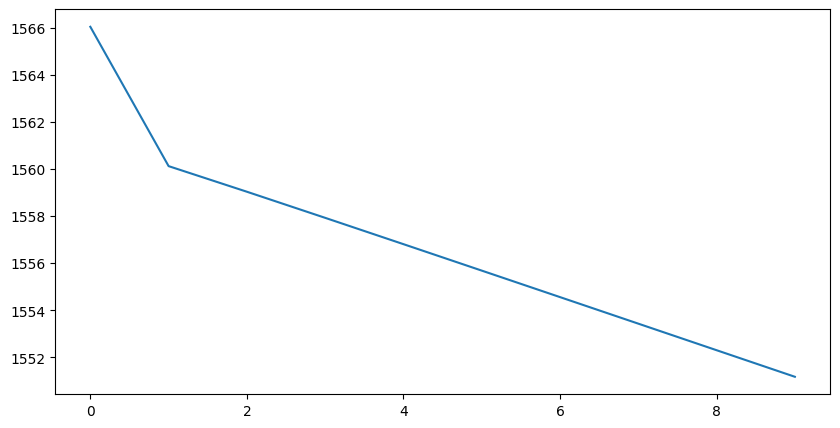

In [220]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, TimeDistributed, LSTM, Dense, Concatenate, RepeatVector, Reshape
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Parameters
total_time_steps = 121  # Total time steps
train_time_steps = 84   # Time steps for training (up to 2027)
test_time_steps = total_time_steps - train_time_steps  # Time steps for testing

map_height = 6    # Map height (matrix)
map_width = 6     # Map width (matrix)
batch_size = 1    # Batch size

# Input tensors for training model
input_oil_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_oil')
input_water_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_water')
input_reservoir_pressure_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_reservoir_pressure')
input_bottomhole_pressure_train = Input(shape=(train_time_steps, map_height, map_width, 1), name='input_bottomhole_pressure')
input_coordinates_train = Input(shape=(map_height, map_width, 2), name='input_coordinates')  # New input

# Input tensors for testing model
input_oil_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_oil')
input_water_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_water')
input_reservoir_pressure_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_reservoir_pressure')
input_bottomhole_pressure_test = Input(shape=(test_time_steps, map_height, map_width, 1), name='input_bottomhole_pressure')
input_coordinates_test = Input(shape=(map_height, map_width, 2), name='input_coordinates')  # New input

# CNN for each type of data
def create_cnn(input_tensor):
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(input_tensor)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(x)
    x = TimeDistributed(Flatten())(x)
    return x

# Training model
cnn_oil_train = create_cnn(input_oil_train)
cnn_water_train = create_cnn(input_water_train)
cnn_reservoir_pressure_train = create_cnn(input_reservoir_pressure_train)
cnn_bottomhole_pressure_train = create_cnn(input_bottomhole_pressure_train)

# Processing coordinates and reshaping
flattened_coordinates_train = Flatten()(input_coordinates_train)
repeated_coordinates_train = RepeatVector(train_time_steps)(flattened_coordinates_train)

# Concatenating all inputs
merged_cnn_train = Concatenate(axis=-1)([cnn_oil_train, cnn_water_train, cnn_reservoir_pressure_train, cnn_bottomhole_pressure_train, repeated_coordinates_train])
lstm_out_train = LSTM(128, return_sequences=False)(merged_cnn_train)
output_train = Dense(map_height * map_width, activation='linear', name='output')(lstm_out_train)
output_train = Reshape((map_height, map_width))(output_train)

model_train = Model(inputs=[input_oil_train, input_water_train, input_reservoir_pressure_train, input_bottomhole_pressure_train, input_coordinates_train], outputs=output_train)
model_train.compile(optimizer='adam', loss='mse')

# Testing model
cnn_oil_test = create_cnn(input_oil_test)
cnn_water_test = create_cnn(input_water_test)
cnn_reservoir_pressure_test = create_cnn(input_reservoir_pressure_test)
cnn_bottomhole_pressure_test = create_cnn(input_bottomhole_pressure_test)

# Processing coordinates and reshaping
flattened_coordinates_test = Flatten()(input_coordinates_test)
repeated_coordinates_test = RepeatVector(test_time_steps)(flattened_coordinates_test)

# Concatenating all inputs
merged_cnn_test = Concatenate(axis=-1)([cnn_oil_test, cnn_water_test, cnn_reservoir_pressure_test, cnn_bottomhole_pressure_test, repeated_coordinates_test])
lstm_out_test = LSTM(128, return_sequences=False)(merged_cnn_test)
output_test = Dense(map_height * map_width, activation='linear', name='output')(lstm_out_test)
output_test = Reshape((map_height, map_width))(output_test)

model_test = Model(inputs=[input_oil_test, input_water_test, input_reservoir_pressure_test, input_bottomhole_pressure_test, input_coordinates_test], outputs=output_test)
model_test.compile(optimizer='adam', loss='mse')

# Loading data from tensors
oil_data = np.expand_dims(loaded_tensors['debit_neft_series.tfrecord'].numpy(), axis=-1)
water_data = np.expand_dims(loaded_tensors['debit_water_series.tfrecord'].numpy(), axis=-1)
reservoir_pressure_data = np.expand_dims(loaded_tensors['debit_plast_pressure_series.tfrecord'].numpy(), axis=-1)
bottomhole_pressure_data = np.expand_dims(loaded_tensors['debit_zaboy_pressure_series.tfrecord'].numpy(), axis=-1)

# Transforming df_X_Y to numpy array of required shape
coordinates_data = np.array(df_X_Y.applymap(lambda x: list(x)).values.tolist())
coordinates_data = coordinates_data.reshape((batch_size, map_height, map_width, 2))

# Checking data shapes
print("Oil data shape:", oil_data.shape)
print("Water data shape:", water_data.shape)
print("Reservoir pressure data shape:", reservoir_pressure_data.shape)
print("Bottomhole pressure data shape:", bottomhole_pressure_data.shape)
print("Coordinates data shape:", coordinates_data.shape)

# Ensure data shapes match expected shape
oil_data = oil_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
water_data = water_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
reservoir_pressure_data = reservoir_pressure_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
bottomhole_pressure_data = bottomhole_pressure_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
coordinates_data = coordinates_data.reshape((batch_size, map_height, map_width, 2))  # New input

# Splitting data into training and test sets
oil_train = oil_data[:, :train_time_steps, :, :, :]
water_train = water_data[:, :train_time_steps, :, :, :]
reservoir_pressure_train = reservoir_pressure_data[:, :train_time_steps, :, :, :]
bottomhole_pressure_train = bottomhole_pressure_data[:, :train_time_steps, :, :, :]
coordinates_train = coordinates_data  # Coordinate data remains constant

oil_test = oil_data[:, train_time_steps:, :, :, :]
water_test = water_data[:, train_time_steps:, :, :, :]
reservoir_pressure_test = reservoir_pressure_data[:, train_time_steps:, :, :, :]
bottomhole_pressure_test = bottomhole_pressure_data[:, train_time_steps:, :, :, :]
coordinates_test = coordinates_data  # Coordinate data remains constant

# Oil production for training and testing for all wells
output_train = oil_data[:, :train_time_steps, :, :, 0].reshape((batch_size, train_time_steps, map_height, map_width))
output_test = oil_data[:, train_time_steps:, :, :, 0].reshape((batch_size, test_time_steps, map_height, map_width))

# Adding EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with validation
history = model_train.fit([oil_train, water_train, reservoir_pressure_train, bottomhole_pressure_train, coordinates_train], 
                          output_train, 
                          epochs=10, 
                          callbacks=[early_stopping])

# Plotting learning curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluating the model on test data
test_loss = model_test.evaluate([oil_test, water_test, reservoir_pressure_test, bottomhole_pressure_test, coordinates_test], output_test)
print(f'Test Loss: {test_loss}')
